In [1]:
!pip install xgboost --quiet
!python -m spacy download en_core_web_lg --quiet

     |████████████████████████████████| 827.9MB 1.2MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
# Data handling
import pandas as pd
from google.colab import files

# numerical calculation
import numpy as np

# Utilities
import sys, os
import re

from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup

# NLP toolkits
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,LancasterStemmer

# Tranditional modelling
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from time import time

import en_core_web_lg
nlp = en_core_web_lg.load()

# Tools & Evaluation metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from pickle import dump

from nltk.corpus import stopwords
from textblob import TextBlob
from google.colab import drive
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from wordcloud import WordCloud
import warnings
import logging
import string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

nltk.download('reuters') # Downloading corpus
nltk.download('stopwords') # Downloading stopwords
nltk.download('punkt') # Downloading tokenizer
nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Greatlearning notebooks/Capstone project'

Mounted at /content/drive
/content/drive/MyDrive/Greatlearning notebooks/Capstone project


In [4]:
logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
pd.set_option('display.max_colwidth', 0)
#print(Path('app.log').read_text())

## Read ticket data file as data frame

In [5]:
ticket_df = pd.read_excel('input_data.xlsx')

# Show head of the data

In [6]:
ticket_df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,spxjnwir pjlcoqds,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


# Shape of the data

In [7]:
ticket_df.shape

(8500, 4)

## Describe data

In [8]:
ticket_df.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


Ticket dataset divided into 2 parts. Dependent features like Short Description, Description and Caller; 
Target variable is Assignment group

# Find any Null values in the data 

In [9]:
ticket_df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [10]:
ticket_df = ticket_df.fillna("")

In [11]:
ticket_df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

## Find any duplicate rows in the dataframe

In [12]:
duplicate = ticket_df[ticket_df.duplicated()]
duplicate.shape

(83, 4)

In [13]:
ticket_df.drop_duplicates(inplace=True)
ticket_df.shape

(8417, 4)

#### Observations:
* The ticket dataset contains 8500 rows and 4 columns
* All 4 columns are of type 'Object'with text information
* There are 9 null values in Short description and 1 null in Description columns
* We have 83 duplicate rows in the dataset

## Analyze the distribution of Assignment Group

In [14]:
targetClassCnt=ticket_df['Assignment group'].value_counts()
targetClassCnt.head()

GRP_0     3934
GRP_8     645 
GRP_24    285 
GRP_12    257 
GRP_9     252 
Name: Assignment group, dtype: int64

In [15]:
targetClassCnt.describe()

count    74.000000  
mean     113.743243 
std      460.731077 
min      1.000000   
25%      5.250000   
50%      26.000000  
75%      81.000000  
max      3934.000000
Name: Assignment group, dtype: float64

In Target variable 'Assignment group', GRP_0 has maximum rows.

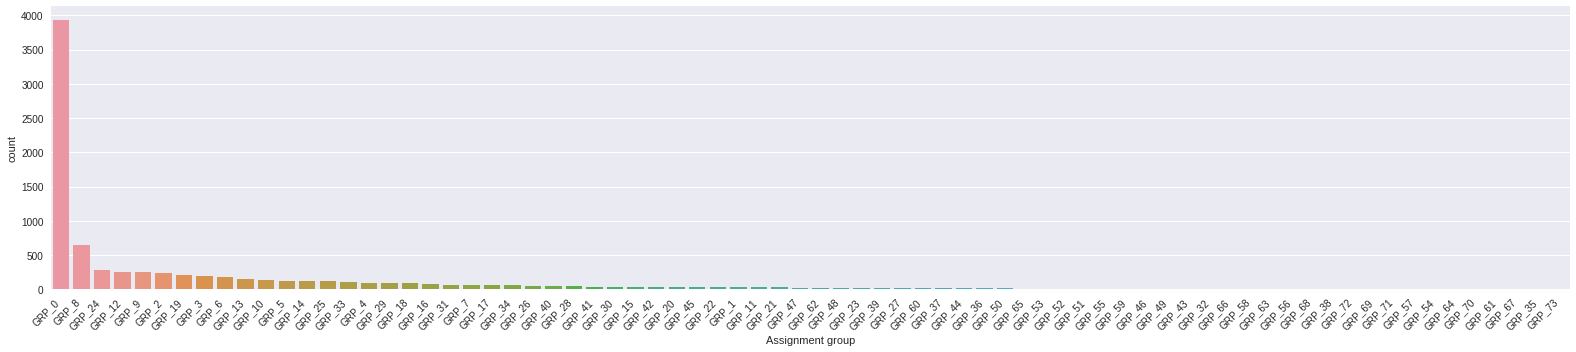

In [16]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of all assignment groups

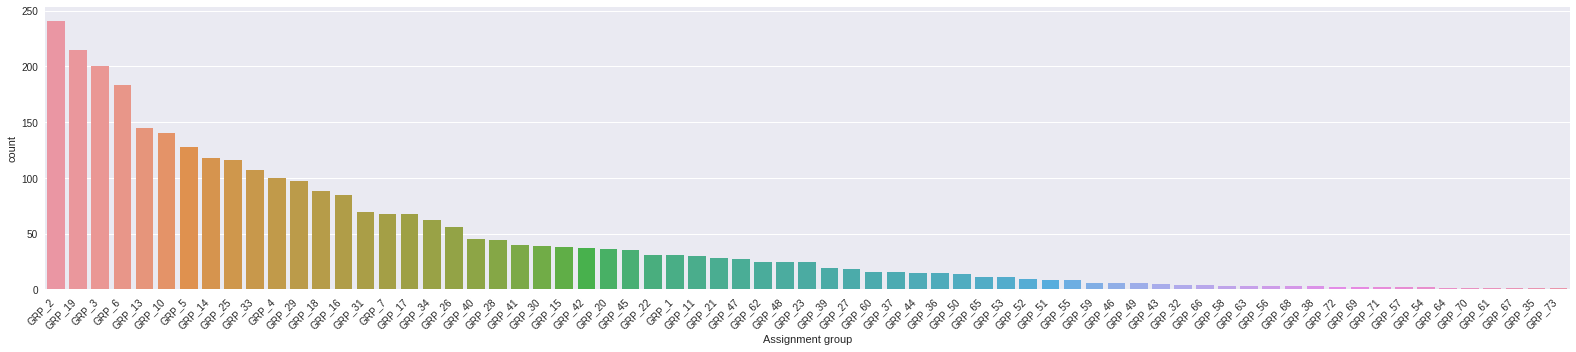

In [17]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order[5:])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of all assignment groups excluding top 5. It looks like data is skewed, we need to fix this by doing data augmentation techniques.

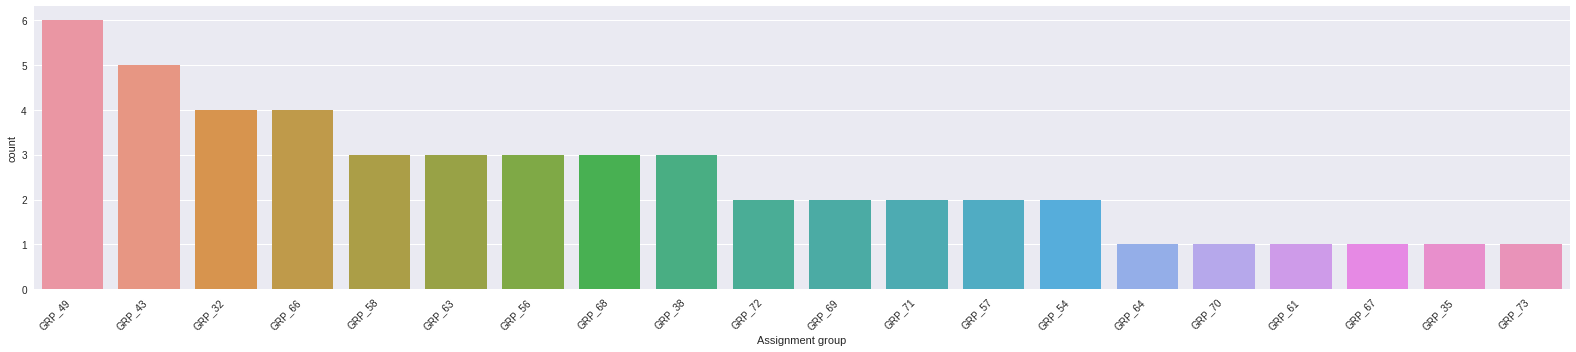

In [18]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order[-20:])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of bottom most 20 assignment groups .

As there are groups with just one ticket, we can club together all groups with less than 3 records into one group and analyze the data

In [19]:
asnGroupBy = ticket_df.groupby(['Assignment group'])
others=[]
for grp in ticket_df['Assignment group'].unique():
  if(asnGroupBy.get_group(grp).shape[0]<5):
    others.append(grp)
print('Found {} groups which have under 5 samples'.format(len(others)))
ticket_df['Assignment group']=ticket_df['Assignment group'].apply(lambda x : 'OTHERS' if x in others  else x)

ticket_df['Assignment group'].unique()

Found 18 groups which have under 5 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'OTHERS', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44', 'GRP_45',
       'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50', 'GRP_51',
       'GRP_52', 'GRP_53', 'GRP_55', 'GRP_59', 'GRP_60', 'GRP_62',
       'GRP_65'], dtype=object)

## Analyse the distribution of Callers

In [20]:
callers = ticket_df['Caller'].unique() 
callers.shape

(2950,)

In [21]:
callersCntDF = ticket_df['Caller'].value_counts()
print(callersCntDF.describe())
callersCntDF.head()

count    2950.000000
mean     2.853220   
std      15.416578  
min      1.000000   
25%      1.000000   
50%      2.000000   
75%      3.000000   
max      788.000000 
Name: Caller, dtype: float64


bpctwhsn kzqsbmtp    788
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    128
rbozivdq gmlhrtvp    72 
rkupnshb gsmzfojw    71 
Name: Caller, dtype: int64

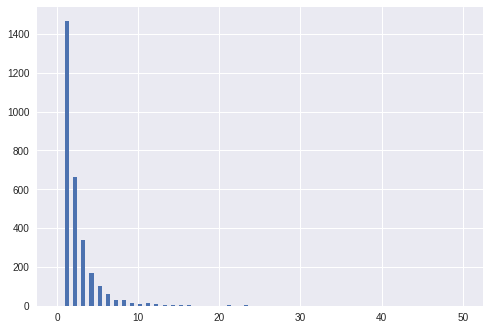

In [22]:
callersCntDF.hist(bins=100,range=(0,50))

Observation: The number of callers who reported more than 10 tickets is very less. And most of the callers have reported 1-2 tickets

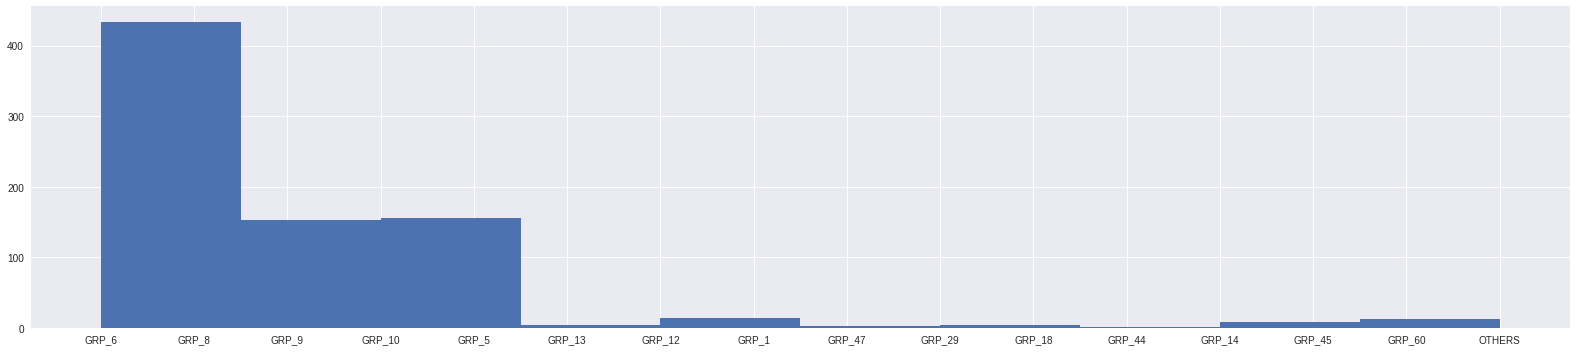

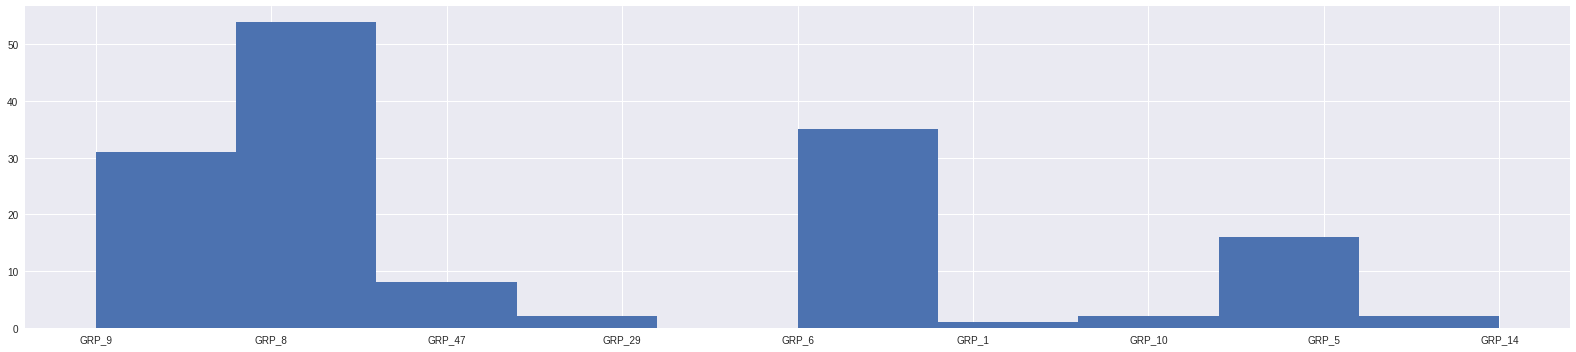

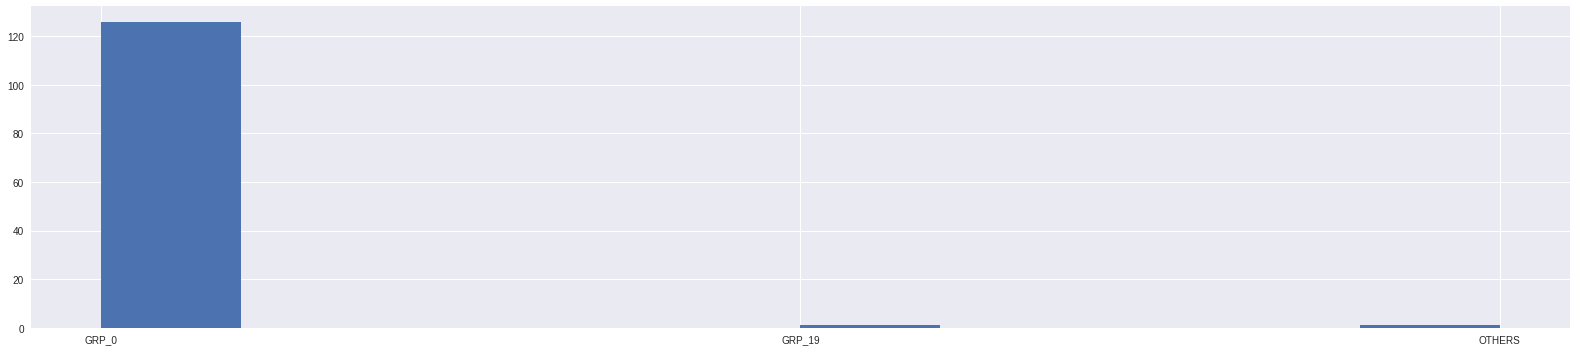

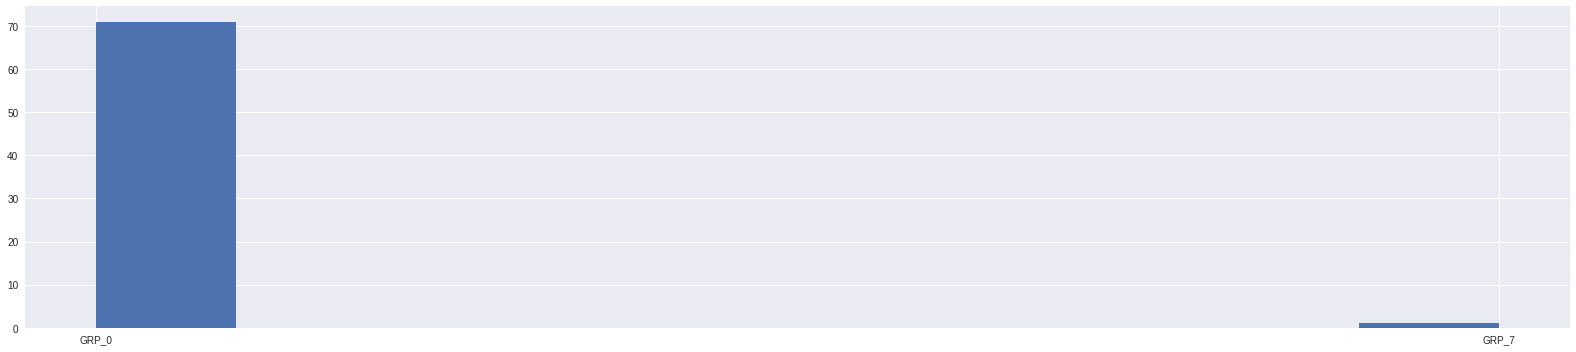

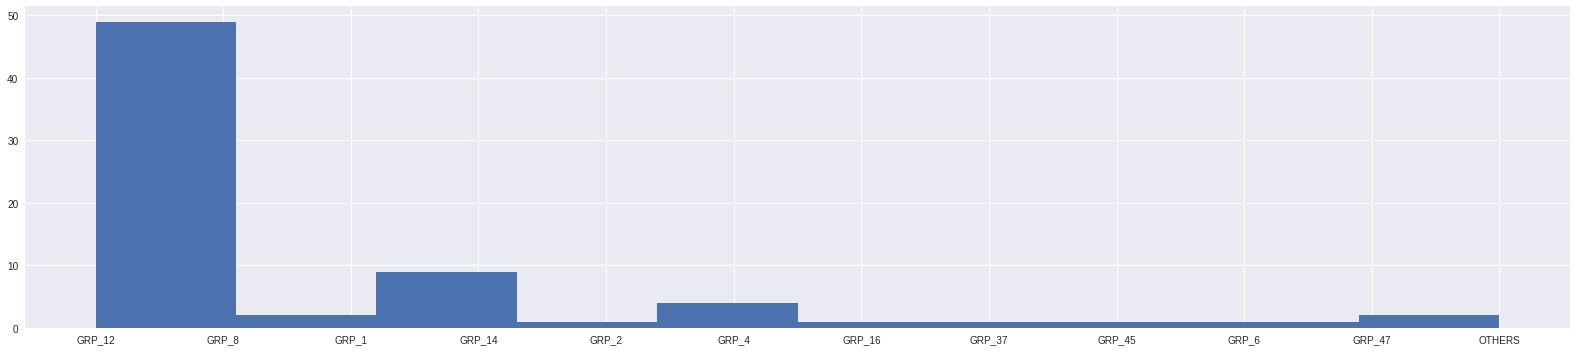

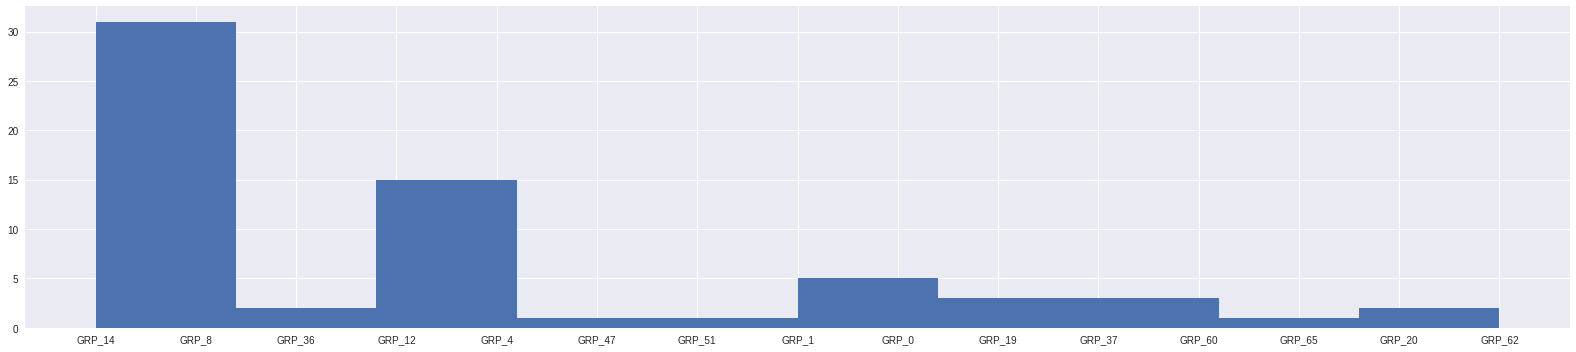

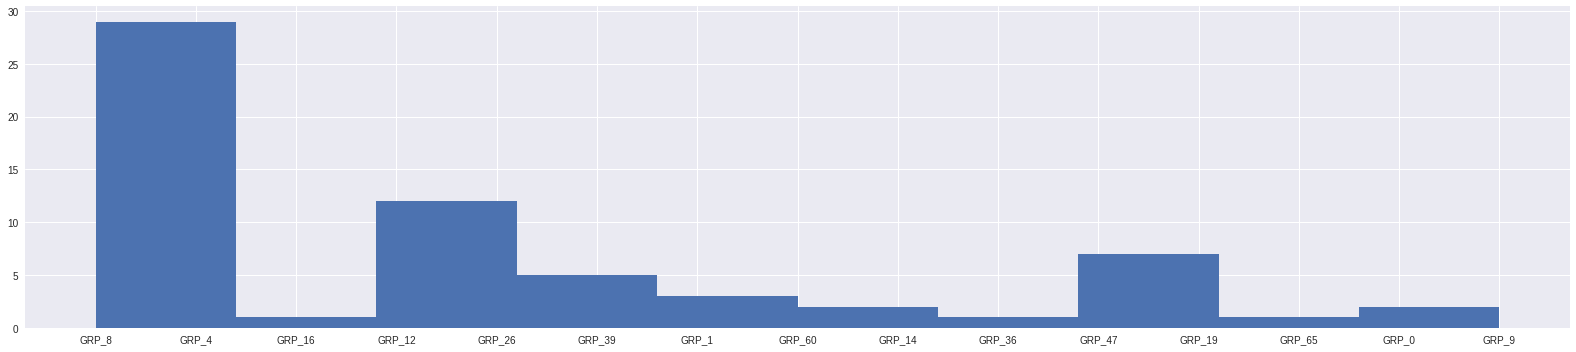

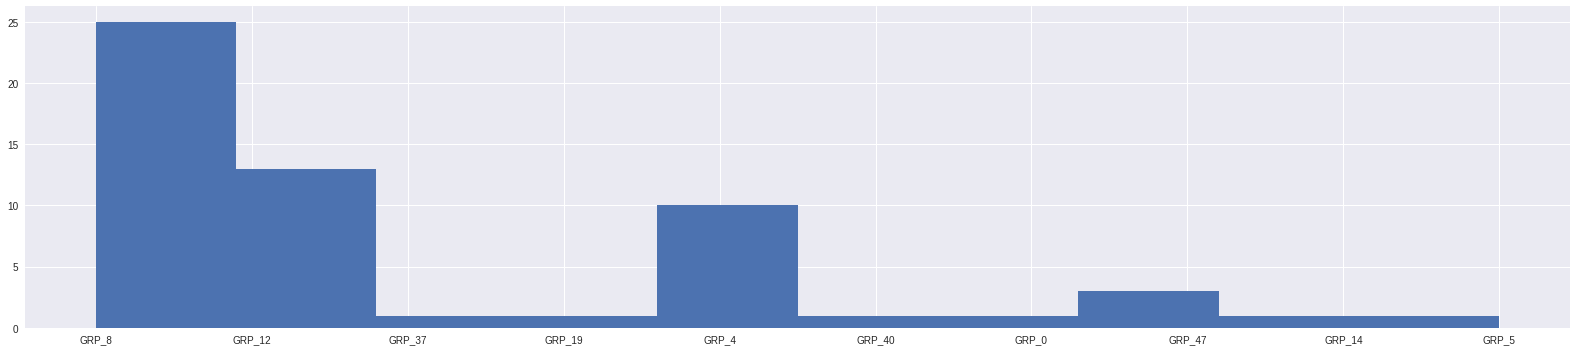

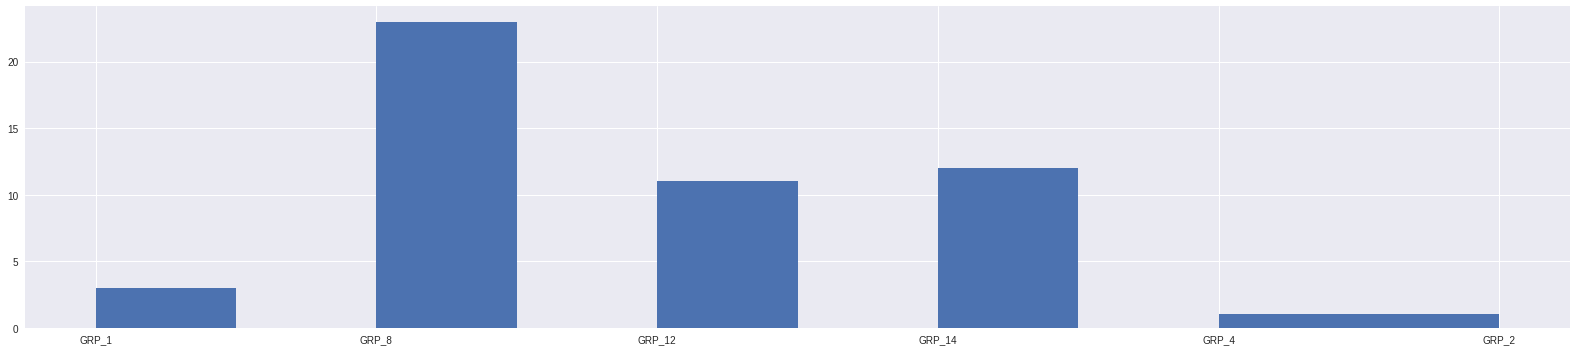

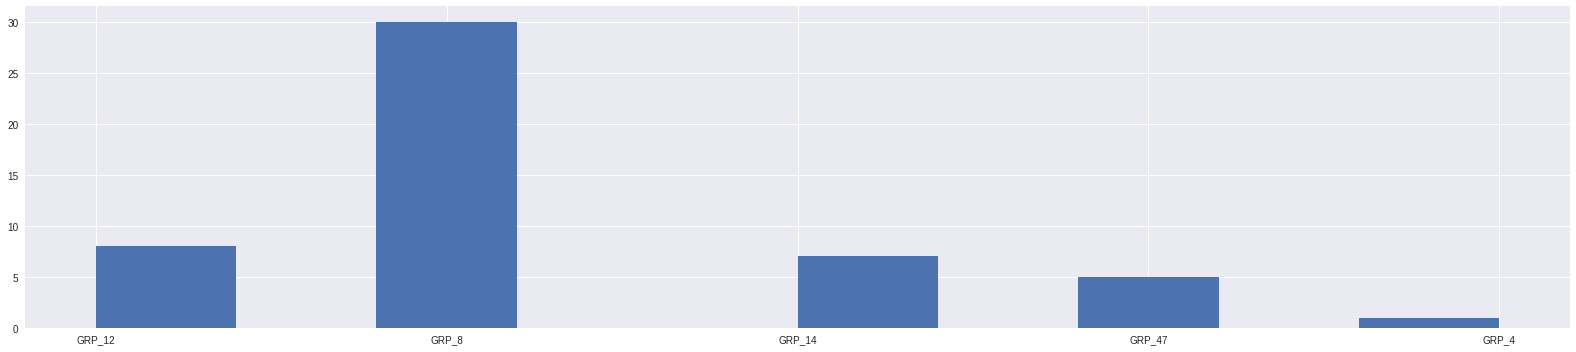

In [23]:
# look at distribution of Assignment Group for 10 most frequent callers
top_10_callers = callersCntDF.index[:10]
for caller in top_10_callers:
  assignment_groups = ticket_df[ticket_df['Caller']==caller]['Assignment group']
  plt.figure(figsize=(22,5))
  assignment_groups.hist()
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

#### Observation: 
* There are 2950 callers have been captured in the entire dataset. 
* The most frequent caller has raised tickets for a variety of Assignment groups.
* 15 callers are identified to be involved in raising tickets for multiple assignment groups


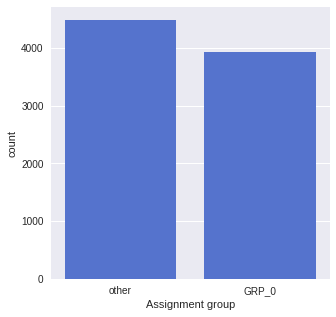

In [24]:
ticket_df_grp0 = ticket_df.copy()
ticket_df_grp0['Assignment group']=ticket_df_grp0['Assignment group'].apply(lambda x : 'other' if x != 'GRP_0'  else x)

descending_order = ticket_df_grp0['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(5,5))
sns.countplot(x='Assignment group', data=ticket_df_grp0, color='royalblue',order=descending_order)

#### Observation: 
* The above plot shows the distribution of samples of GRP_0 vs all other groups combined. 
* Large no of entries in GRP_0 (having count of 3976 entries) which account for ~50% of the data
* We need to fix the imbalance in the data using data augmentation techniques

In [25]:
ticket_df['sd_len'] = ticket_df['Short description'].astype(str).apply(len)
ticket_df['sd_word_count'] = ticket_df['Short description'].apply(lambda x: len(str(x).split()))
ticket_df['ld_len'] = ticket_df['Description'].astype(str).apply(len)
ticket_df['ld_word_count'] = ticket_df['Description'].apply(lambda x: len(str(x).split()))

In [26]:
ticket_df.head()

,Short description,Description,Caller,Assignment group,sd_len,sd_word_count,ld_len,ld_word_count
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,spxjnwir pjlcoqds,GRP_0,11,2,206,33
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",hmjdrvpb komuaywn,GRP_0,7,1,194,25
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,eylqgodm ybqkwiam,GRP_0,18,5,87,11
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,29,5,29,5
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,12,2,12,2


In [27]:
ticket_df['sd_len'].describe()

count    8417.000000
mean     47.253059  
std      27.068818  
min      0.000000   
25%      26.000000  
50%      41.000000  
75%      62.000000  
max      159.000000 
Name: sd_len, dtype: float64

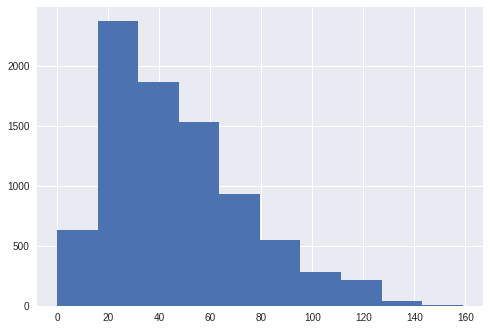

In [28]:
ticket_df['sd_len'].hist()

In [29]:
ticket_df['sd_len'].value_counts()[-20:]

131    3
127    3
133    3
125    3
145    2
141    2
137    2
144    2
135    2
159    2
138    1
2      1
151    1
140    1
1      1
136    1
149    1
134    1
142    1
150    1
Name: sd_len, dtype: int64

Description: There are some single character short descriptions as well. However majority of the short description is not beyound 62 characters

In [30]:
ticket_df['ld_len'].describe()

count    8417.000000 
mean     205.498753  
std      521.952353  
min      0.000000    
25%      42.000000   
50%      106.000000  
75%      203.000000  
max      13001.000000
Name: ld_len, dtype: float64

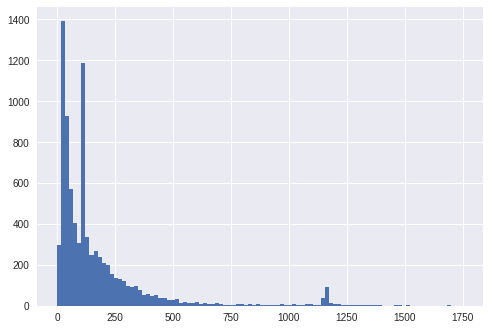

In [31]:
ticket_df['ld_len'].hist(bins=100, range=(0,1750))

In [32]:
ticket_df['ld_len'].value_counts()[-20:]

1347    1
1379    1
1387    1
1515    1
1659    1
1795    1
644     1
1839    1
4286    1
2293    1
388     1
468     1
516     1
532     1
564     1
588     1
596     1
612     1
628     1
0       1
Name: ld_len, dtype: int64

Description: There are some single character descriptions as well. However majority of the short description is not beyound 201 characters

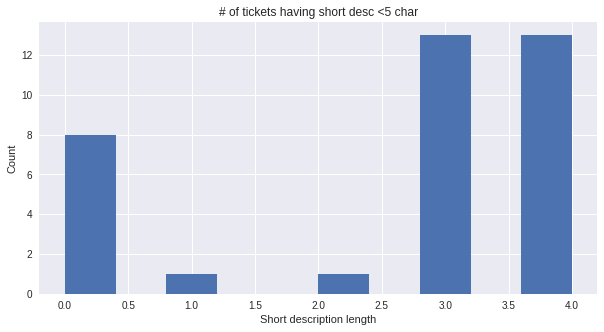

In [33]:
sd_len_FiveChar = ticket_df[ticket_df["sd_len"] < 5]
plt.xlabel('Short description length')
plt.ylabel('Count')
plt.title('# of tickets having short desc <5 char')
sd_len_FiveChar['sd_len'].hist(bins=10, figsize=(10,5))

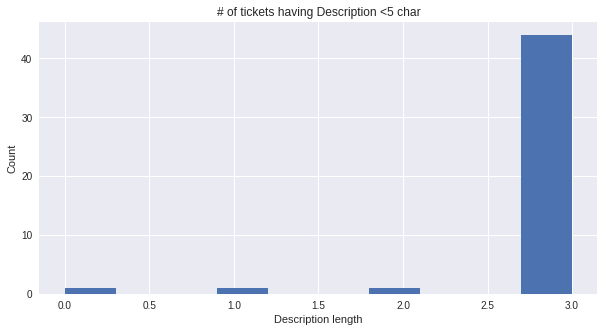

In [34]:
sd_len_FiveChar = ticket_df[ticket_df["ld_len"] < 5]
plt.xlabel('Description length')
plt.ylabel('Count')
plt.title('# of tickets having Description <5 char')
sd_len_FiveChar['ld_len'].hist(bins=10, figsize=(10,5))

In [35]:
ticket_df_temp =  ticket_df.copy()
ticket_df_temp['num_words'] = ticket_df['Description'].apply(lambda x : len(x.split()))
ticket_df_temp.describe()

,sd_len,sd_word_count,ld_len,ld_word_count,num_words
count,8417.000000,8417.000000,8417.000000,8417.000000,8417.000000
mean,47.253059,6.939290,205.498753,27.471902,27.471902
std,27.068818,4.133266,521.952353,65.319593,65.319593
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,4.000000,42.000000,6.000000,6.000000
50%,41.000000,6.000000,106.000000,11.000000,11.000000
75%,62.000000,9.000000,203.000000,28.000000,28.000000
max,159.000000,28.000000,13001.000000,1625.000000,1625.000000


Text(0.5, 1.0, 'Word distribution per bin')

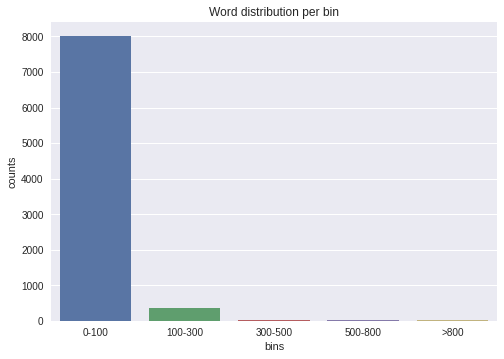

In [36]:
ticket_df_temp['bins']=pd.cut(ticket_df_temp.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])
word_distribution = ticket_df_temp.groupby('bins').size().reset_index().rename(columns={0:'counts'})
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

Observation: Most of the samples had word count within 100

Common class/methods for data cleansing 
* Convert each character in a sentence to lowercase character
* Remove HTML Tags
* Remove Email contacts
* Remove punctuations, hyperlinks
* Remove stopwords
* Remove common words like com, hello
* Remove New line characters
* Stemming was causing invalid words, hence used a lemmatizer

In [37]:
class PreProcessing:
    lemmatizer=""
    stemmer =""
    tokenizer=""
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = LancasterStemmer()
        self.tokenizer = RegexpTokenizer(r'\w+')
    
    def data_clean(self, sentence):
      if pd.isnull(sentence):
        return sentence
      sentence= sentence.lower()
      sentence = ' '.join([w for w in sentence.split() if not self.is_valid_date(w)])
      sentence = re.sub(r"received from:",' ',sentence)
      sentence = re.sub(r"select the following link to view the disclaimer in an alternate language.",' ',sentence)
      sentence = re.sub(r"from:",' ',sentence)
      sentence = re.sub(r"to:",' ',sentence)
      sentence = re.sub(r"subject:",' ',sentence)
      sentence = re.sub(r"re:",' ',sentence)
      sentence = re.sub(r"fw:",' ',sentence)
      sentence = re.sub(r"sent:",' ',sentence)
      sentence = re.sub(r"ic:",' ',sentence)
      sentence = re.sub(r"cc:",' ',sentence)
      sentence = re.sub(r"bcc:",' ',sentence)
      tok = WordPunctTokenizer()
      pat1 = r'@[A-Za-z0-9]+'
      pat2 = r'https?://[A-Za-z0-9./]+'
      combined_pat = r'|'.join((pat1, pat2))
    
    
      soup = BeautifulSoup(sentence, 'lxml')
      souped = soup.get_text()
      stripped = re.sub(combined_pat, '', souped)
      try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
      except:
        clean = stripped
      letters_only = re.sub("[^a-zA-Z]", " ", clean)
      words = tok.tokenize(letters_only)
      sentence=(" ".join(words)).strip()
      #Remove email 
      sentence = re.sub(r'\S*@\S*\s?', '', sentence)
      # Remove underscores
      sentence = re.sub(r'\_',' ', sentence)

      # Remove new line characters 
      sentence = re.sub(r'\n',' ',sentence)
      # Remove hashtag while keeping hashtag sentence
      sentence = re.sub(r'#','', sentence)
      #& 
      sentence = re.sub(r'&;?', 'and',sentence)
      # Remove HTML special entities (e.g. &amp;)
      sentence = re.sub(r'\&\w*;', '', sentence)
      # Remove hyperlinks
      sentence = re.sub(r'https?:\/\/.*\/\w*', '', sentence)  
      # Remove characters beyond Readable formart by Unicode:
      sentence= ''.join(c for c in sentence if c <= '\uFFFF') 
      sentence = sentence.strip()
      # Remove unreadable characters  (also extra spaces)
      sentence = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", sentence).split())

      # Single character      
      sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
      sentence = sentence.strip()
      return sentence
    
    def is_valid_date(self,date_str):
      try:
        parser.parse(date_str)
        return True
      except:
        return False
    
    def mergeColumns(self, df):
        df['desc']=df['Short description'] + " " + df['Description']
        df.drop("Short description", axis=1, inplace=True)
        df.drop("Description", axis=1, inplace=True)
        df.drop("Caller", axis=1, inplace=True)
        return df

    def remove_punctuation(self, sentence):
      try:
        no_punct = "".join([c for c in sentence if c not in string.punctuation])
        return no_punct
      except:
        print("remove_punctuation: sentence,",sentence)
        return sentence

    def make_tokens(self, sentence):
      return self.tokenizer.tokenize(sentence.lower())

    def remove_stopwords(self, words):
      return [w for w in words if w not in stopwords.words('english')]

    def word_lemmatize(self, words):
      return [self.lemmatizer.lemmatize(item) for item in words]


preProcessing=PreProcessing()

In [38]:
# merging two description columns and doing cleaning
ticket_df=preProcessing.mergeColumns(ticket_df)
ticket_df['desc_clean'] = ticket_df['desc'].apply(preProcessing.data_clean)

In [39]:
ticket_df.head()

,Assignment group,sd_len,sd_word_count,ld_len,ld_word_count,desc,desc_clean
0,GRP_0,11,2,206,33,login issue -verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,login issue verified user details employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved
1,GRP_0,7,1,194,25,"outlook \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",outlook hmjdrvpb komuaywn com hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind
2,GRP_0,18,5,87,11,cant log in to vpn \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,cant log in to vpn eylqgodm ybqkwiam com hi cannot log on to vpn best
3,GRP_0,29,5,29,5,unable to access hr_tool page unable to access hr_tool page,unable to access hr tool page unable to access hr tool page
4,GRP_0,12,2,12,2,skype error skype error,skype error skype error


In [40]:
ticket_df['desc_punct'] = ticket_df['desc_clean'].map(preProcessing.remove_punctuation)
ticket_df['desc_token'] = ticket_df['desc_punct'].map(preProcessing.make_tokens)
ticket_df['desc_stop'] = ticket_df['desc_token'].map(preProcessing.remove_stopwords)
ticket_df['desc_lemma'] = ticket_df['desc_stop'].map(preProcessing.word_lemmatize)

In [41]:
ticket_df.head()

,Assignment group,sd_len,sd_word_count,ld_len,ld_word_count,desc,desc_clean,desc_punct,desc_token,desc_stop,desc_lemma
0,GRP_0,11,2,206,33,login issue -verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,login issue verified user details employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved,login issue verified user details employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved,"[login, issue, verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset, the, password, advised, the, user, to, login, and, check, caller, confirmed, that, he, was, able, to, login, issue, resolved]","[login, issue, verified, user, details, employee, manager, name, checked, user, name, ad, reset, password, advised, user, login, check, caller, confirmed, able, login, issue, resolved]","[login, issue, verified, user, detail, employee, manager, name, checked, user, name, ad, reset, password, advised, user, login, check, caller, confirmed, able, login, issue, resolved]"
1,GRP_0,7,1,194,25,"outlook \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",outlook hmjdrvpb komuaywn com hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind,outlook hmjdrvpb komuaywn com hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind,"[outlook, hmjdrvpb, komuaywn, com, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, outlook, calendar, can, somebody, please, advise, how, to, correct, this, kind]","[outlook, hmjdrvpb, komuaywn, com, hello, team, meetings, skype, meetings, etc, appearing, outlook, calendar, somebody, please, advise, correct, kind]","[outlook, hmjdrvpb, komuaywn, com, hello, team, meeting, skype, meeting, etc, appearing, outlook, calendar, somebody, please, advise, correct, kind]"
2,GRP_0,18,5,87,11,cant log in to vpn \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,cant log in to vpn eylqgodm ybqkwiam com hi cannot log on to vpn best,cant log in to vpn eylqgodm ybqkwiam com hi cannot log on to vpn best,"[cant, log, in, to, vpn, eylqgodm, ybqkwiam, com, hi, cannot, log, on, to, vpn, best]","[cant, log, vpn, eylqgodm, ybqkwiam, com, hi, cannot, log, vpn, best]","[cant, log, vpn, eylqgodm, ybqkwiam, com, hi, cannot, log, vpn, best]"
3,GRP_0,29,5,29,5,unable to access hr_tool page unable to access hr_tool page,unable to access hr tool page unable to access hr tool page,unable to access hr tool page unable to access hr tool page,"[unable, to, access, hr, tool, page, unable, to, access, hr, tool, page]","[unable, access, hr, tool, page, unable, access, hr, tool, page]","[unable, access, hr, tool, page, unable, access, hr, tool, page]"
4,GRP_0,12,2,12,2,skype error skype error,skype error skype error,skype error skype error,"[skype, error, skype, error]","[skype, error, skype, error]","[skype, error, skype, error]"


In [42]:
combined_desc = ticket_df['desc_stop'].values.tolist()

In [43]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(combined_desc))

In [44]:
all_words = []
for i in range(len(data_words)): #Traversing through the main list
  for j in range (len(data_words[i])): #Traversing through each sublist
    all_words.append(data_words[i][j])

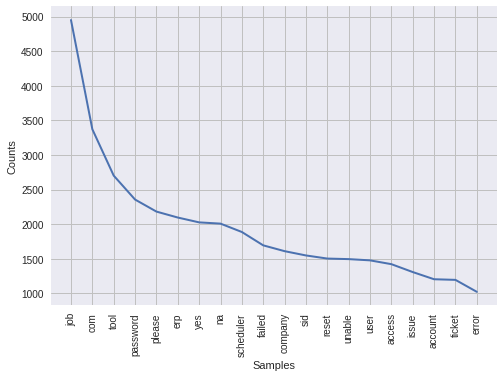

In [45]:
word_freq = nltk.FreqDist(all_words)
word_freq.plot(20)

In [46]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)    
print(data_words_bigrams[1])

['outlook', 'hmjdrvpb', 'komuaywn', 'com', 'hello', 'team', 'meetings', 'skype', 'meetings', 'etc', 'appearing', 'outlook', 'calendar', 'somebody', 'please', 'advise', 'correct', 'kind']


In [47]:
wordclouds=' '.join(map(str, data_words_bigrams)) 

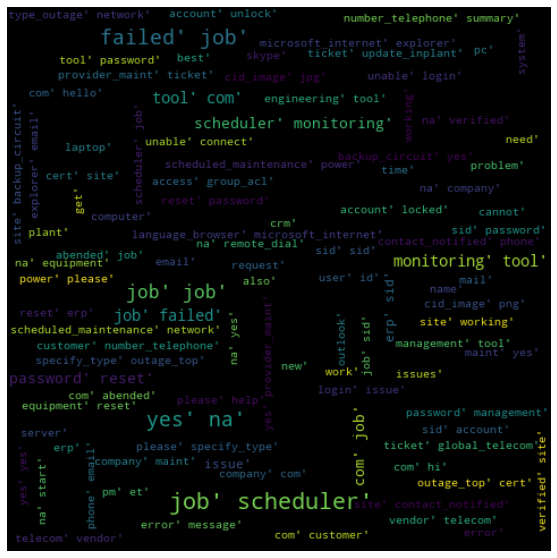

In [48]:
wordcloud = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10).generate(wordclouds)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

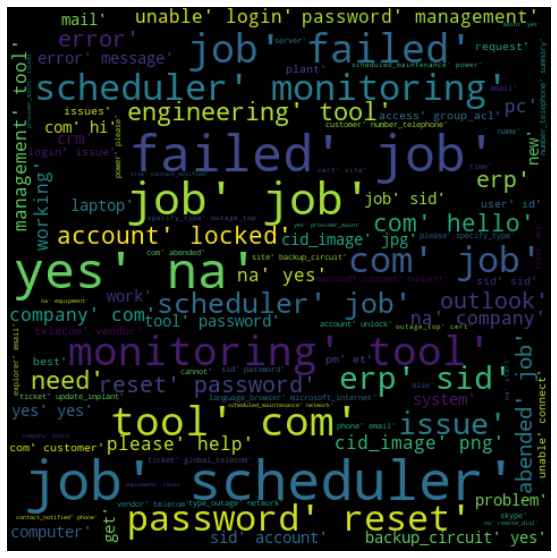

In [49]:
wordcloud_2 = WordCloud(width=480, height=480, max_words=100).generate(wordclouds)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [50]:
def wordcloud_grp(f, x):
    wordclouds_by_grp =' '.join(map(str, f))
    wc = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10, max_words=50).generate(wordclouds_by_grp)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most common 50 words of {}".format(x))
    plt.margins(x=0, y=0)
    plt.show()

In [51]:
value = targetClassCnt.sort_values(ascending=False).index
value

Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25',
       'GRP_33', 'GRP_4', 'GRP_29', 'GRP_18', 'GRP_16', 'GRP_31', 'GRP_7',
       'GRP_17', 'GRP_34', 'GRP_26', 'GRP_40', 'GRP_28', 'GRP_41', 'GRP_30',
       'GRP_15', 'GRP_42', 'GRP_20', 'GRP_45', 'GRP_22', 'GRP_1', 'GRP_11',
       'GRP_21', 'GRP_47', 'GRP_62', 'GRP_48', 'GRP_23', 'GRP_39', 'GRP_27',
       'GRP_60', 'GRP_37', 'GRP_44', 'GRP_36', 'GRP_50', 'GRP_65', 'GRP_53',
       'GRP_52', 'GRP_51', 'GRP_55', 'GRP_59', 'GRP_46', 'GRP_49', 'GRP_43',
       'GRP_32', 'GRP_66', 'GRP_58', 'GRP_63', 'GRP_56', 'GRP_68', 'GRP_38',
       'GRP_72', 'GRP_69', 'GRP_71', 'GRP_57', 'GRP_54', 'GRP_64', 'GRP_70',
       'GRP_61', 'GRP_67', 'GRP_35', 'GRP_73'],
      dtype='object')

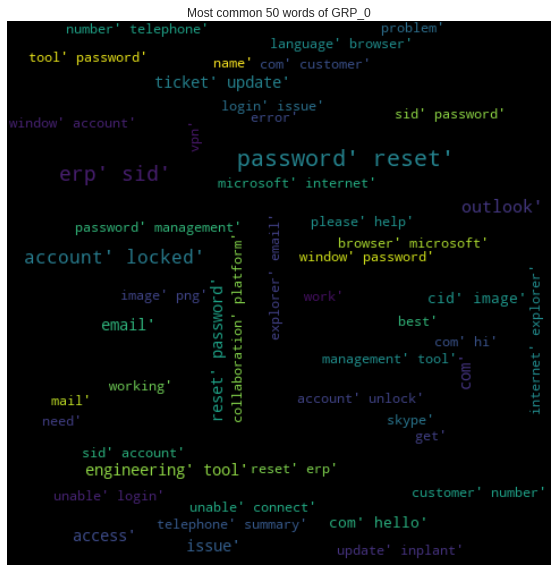

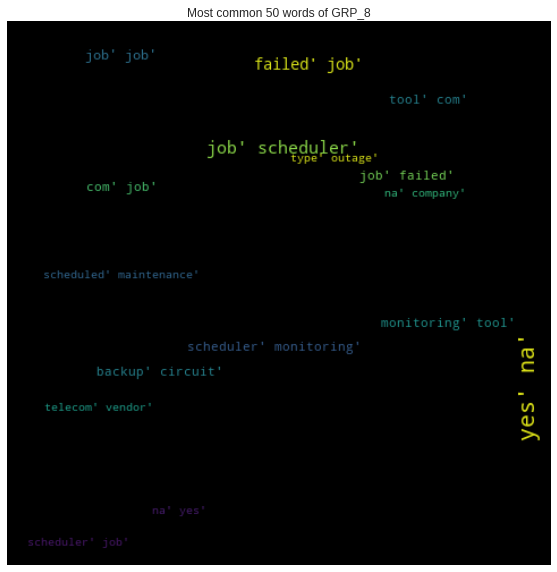

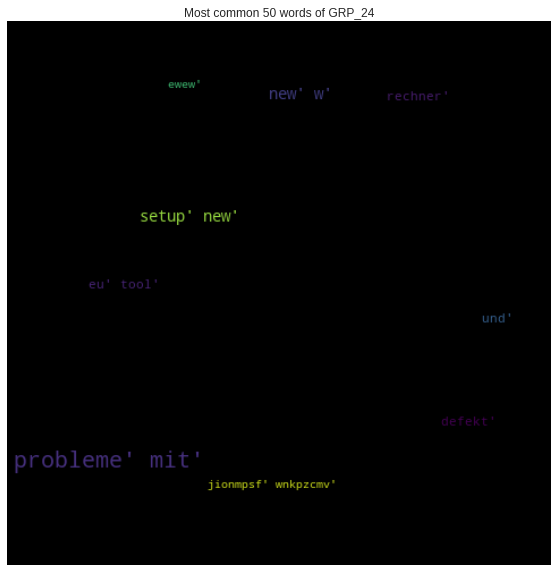

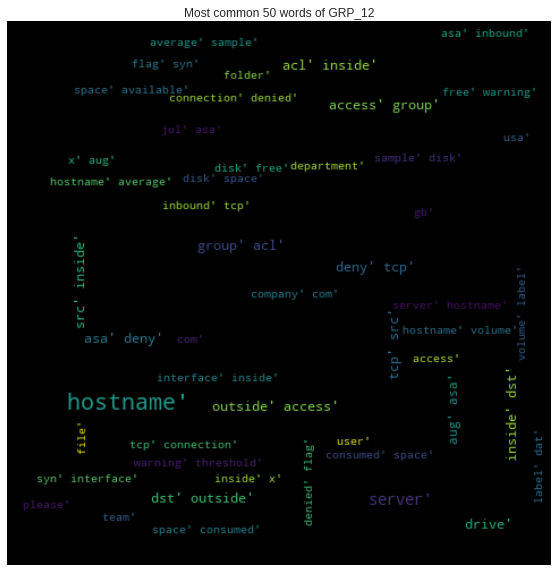

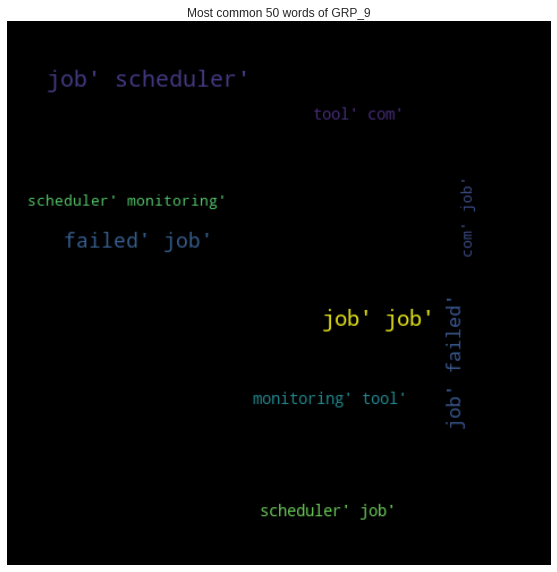

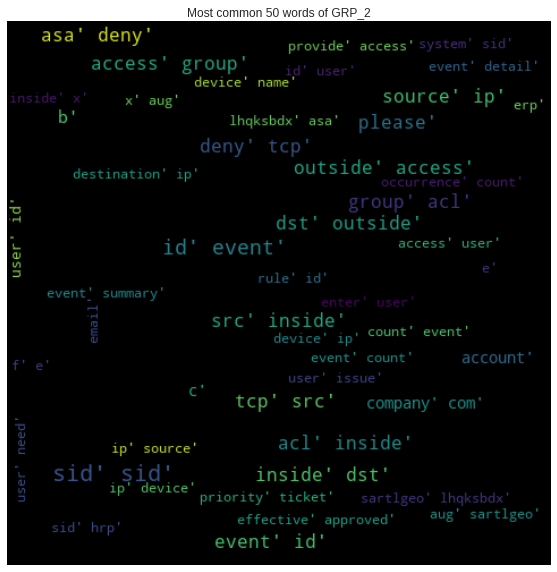

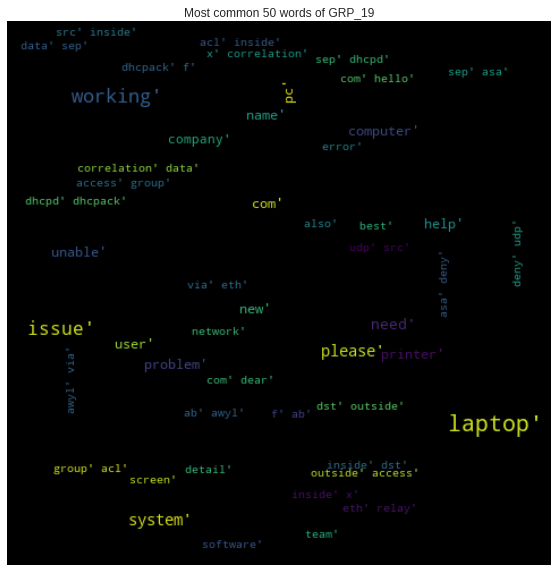

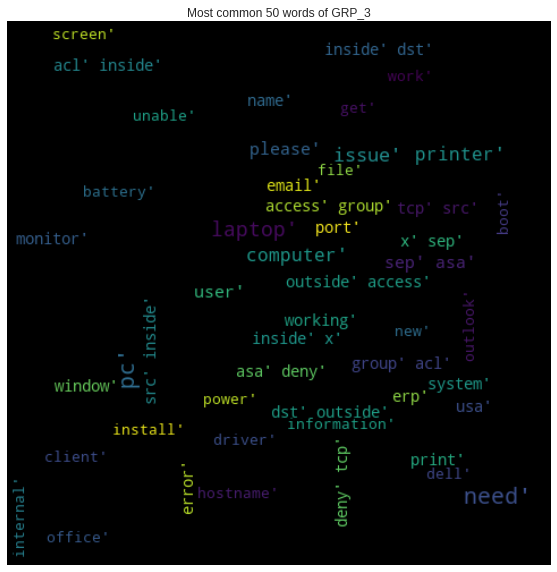

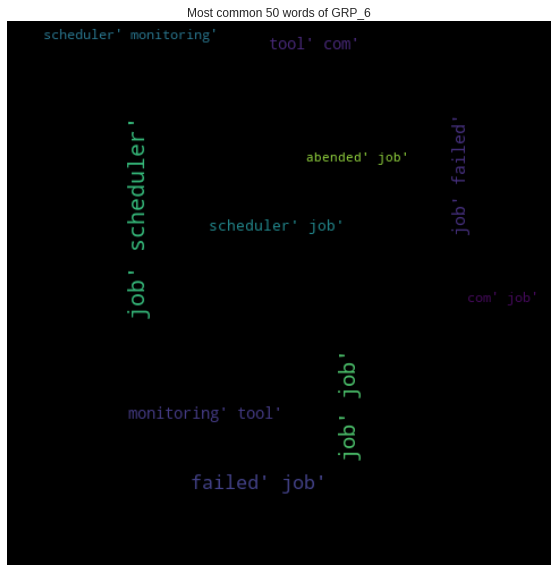

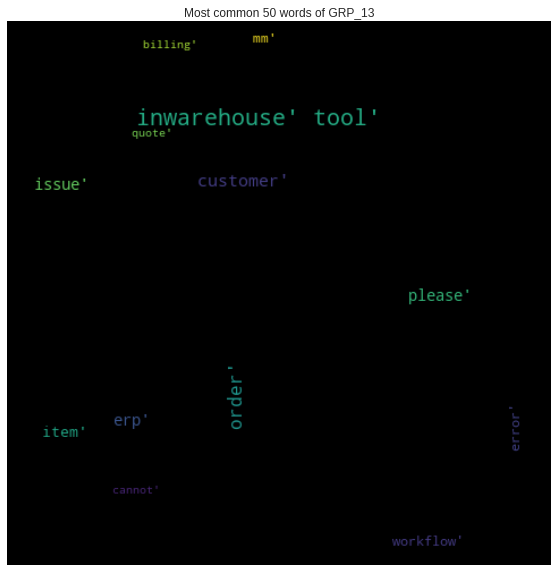

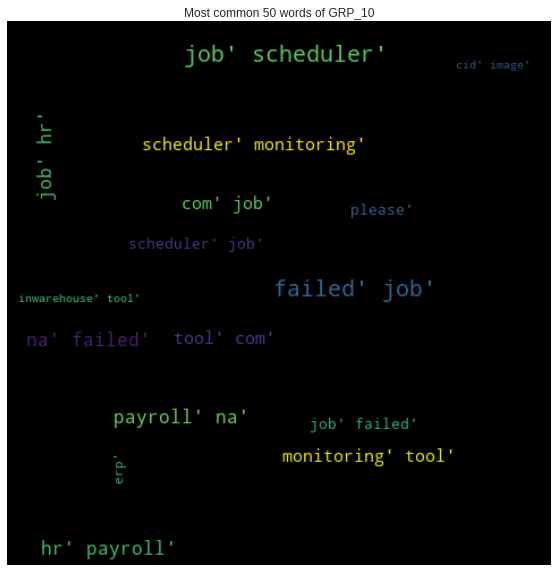

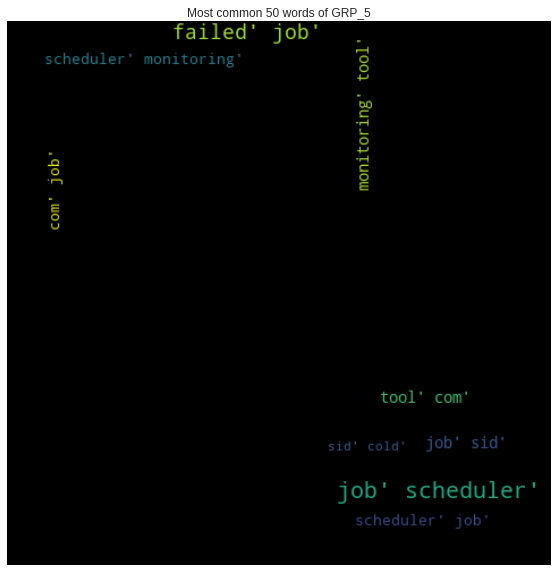

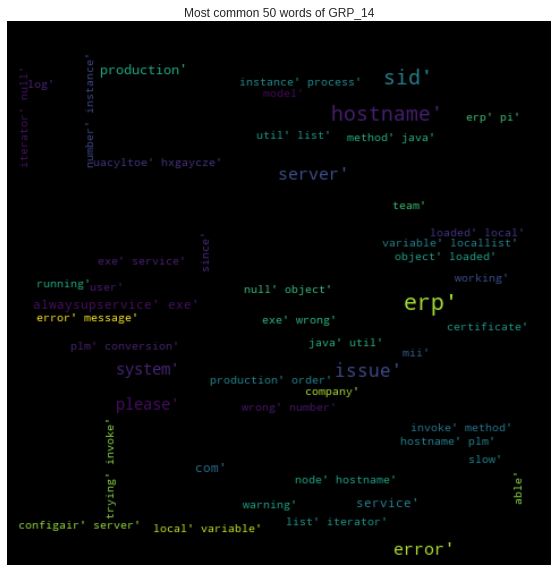

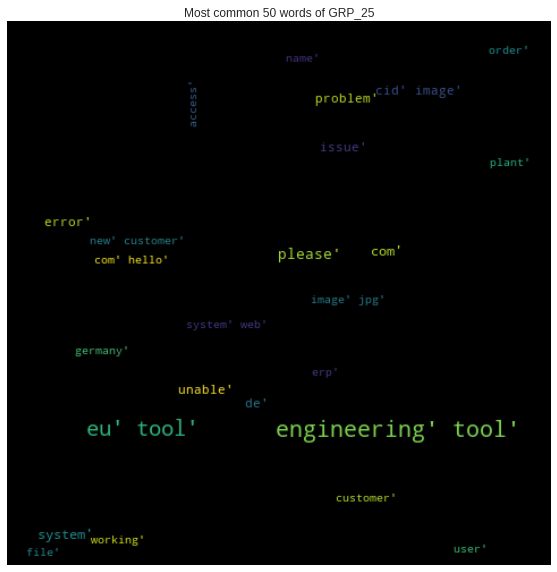

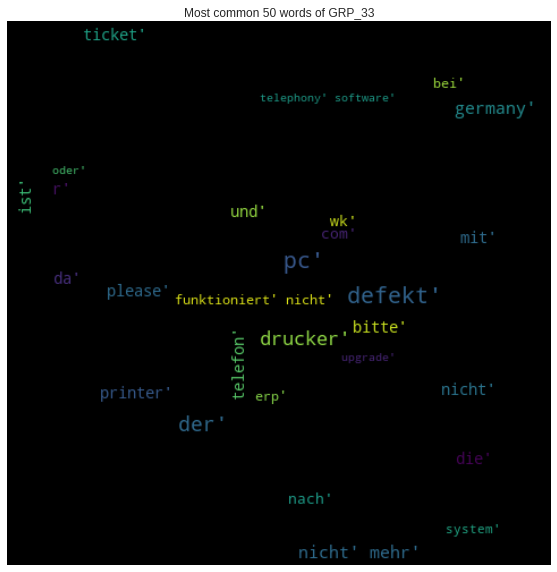

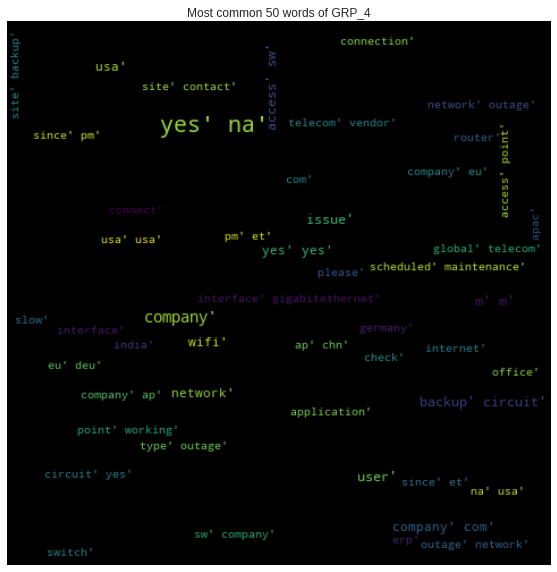

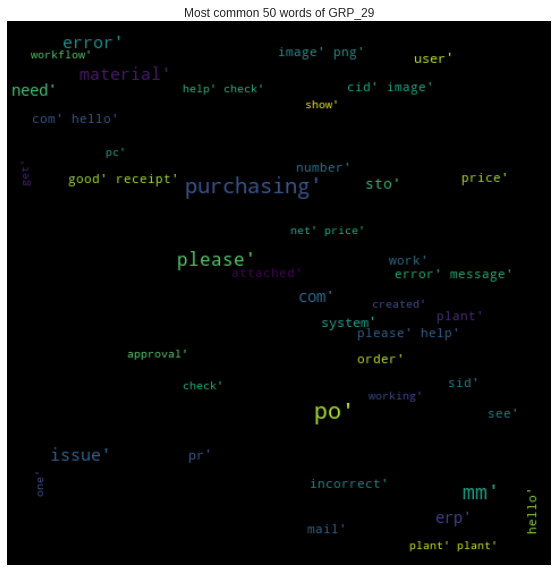

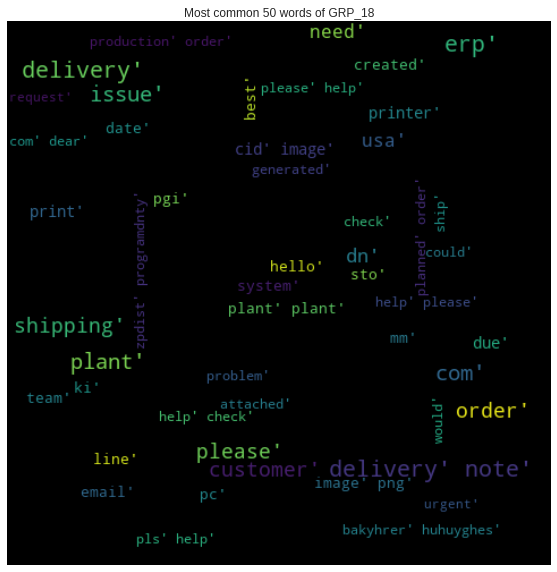

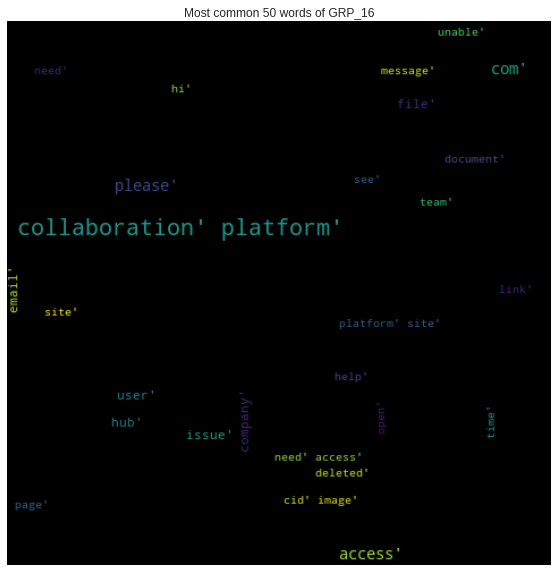

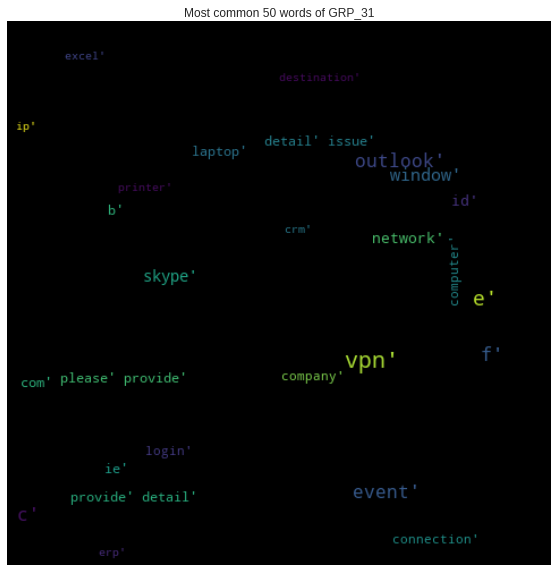

In [52]:
for i in range(20):

    Grp = ticket_df[ticket_df ['Assignment group'] == value[i]]
    Grp = Grp['desc_lemma']
    wordcloud_grp(Grp,value[i])

In [53]:
ticket_df.reset_index(inplace=True)

## Finding the simmilarity between the assigment groups

In [54]:
def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))

    return cleaned_words

In [55]:
def cosine_distance_wordembedding_method(s1, s2):
    import scipy
    vector_1=[]
    for word in preprocess(s1):
      if word in model:
        vector_1.append(np.mean(model[word],axis=0))
    vector_2=[]
    for word in preprocess(s2):
      if word in model:
        vector_2.append(np.mean(model[word],axis=0))
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1-cosine)*100,2),'%')

In [56]:
corpus=ticket_df.copy()

In [57]:
corpus['result']=corpus[['desc_clean','Assignment group']].groupby(['Assignment group'])['desc_clean'].transform(lambda x: " ".join(x))

In [58]:
result_df=corpus[['result','Assignment group']].drop_duplicates()

In [59]:
result_df.reset_index(inplace=True)

In [60]:
similarity_df = pd.DataFrame(index=result_df['Assignment group'].unique(), columns=result_df['Assignment group'].unique())
similarity_df = similarity_df.fillna(0)

In [61]:
def get_cosine(s1,s2):
  l1 =[];l2 =[] 
  X_set=set(preprocess(s1))
  Y_set=set(preprocess(s2))
  rvector = X_set.union(Y_set)  
  for w in rvector: 
      if w in X_set: l1.append(1) # create a vector 
      else: l1.append(0) 
      if w in Y_set: l2.append(1) 
      else: l2.append(0) 
  c = 0
    
  # cosine formula  
  for i in range(len(rvector)): 
          c+= l1[i]*l2[i] 
  cosine = c / float((sum(l1)*sum(l2))**0.5) 
  return cosine;

In [62]:
a=0
for i in range(similarity_df.shape[0]):
  for j in range(similarity_df.shape[0]):
    a=get_cosine(result_df['result'][i],result_df['result'][j])+0
    similarity_df.at[result_df['Assignment group'][i],result_df['Assignment group'][j]]=round((a)*100,2)

In [63]:
similarity_df.values[[np.arange(similarity_df.shape[0])]*2] = 0

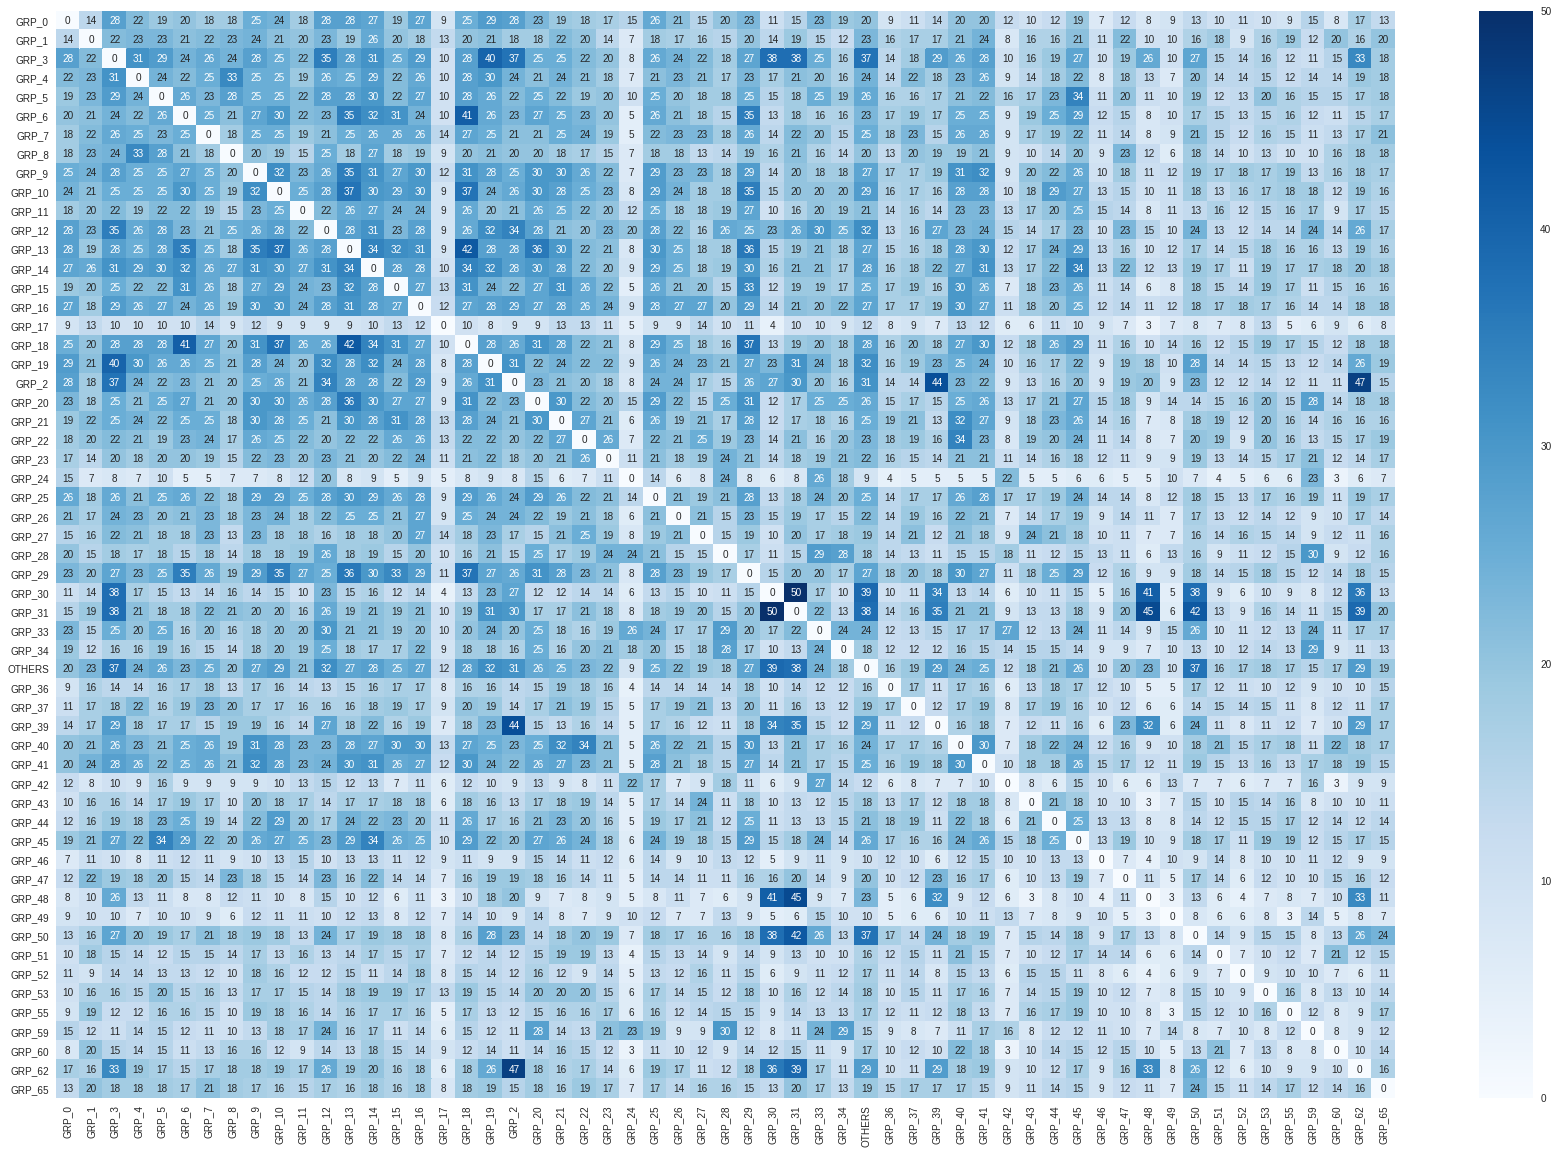

In [64]:
plt.figure(figsize=(30,20))
sns.heatmap(similarity_df, annot=True,cmap= 'Blues')

By looking at the heat map we observed that there is no group having more than 50% similarity. So we are considering all 57 groups.

# Data augmentation

In [65]:
df_minor_grps = ticket_df[ticket_df['Assignment group'] != 'GRP_0']
df_grp0 = ticket_df[ticket_df['Assignment group'] == 'GRP_0']
max_others = df_minor_grps['Assignment group'].value_counts().max()
df_resampled = df_grp0.copy()
for grp in df_minor_grps['Assignment group'].unique():
    df_single_grp = ticket_df[ticket_df['Assignment group'] == grp]
    resampled = resample(df_single_grp, replace=True, n_samples=int(max_others),stratify=None , random_state=123)
    df_resampled = df_resampled.append(resampled)

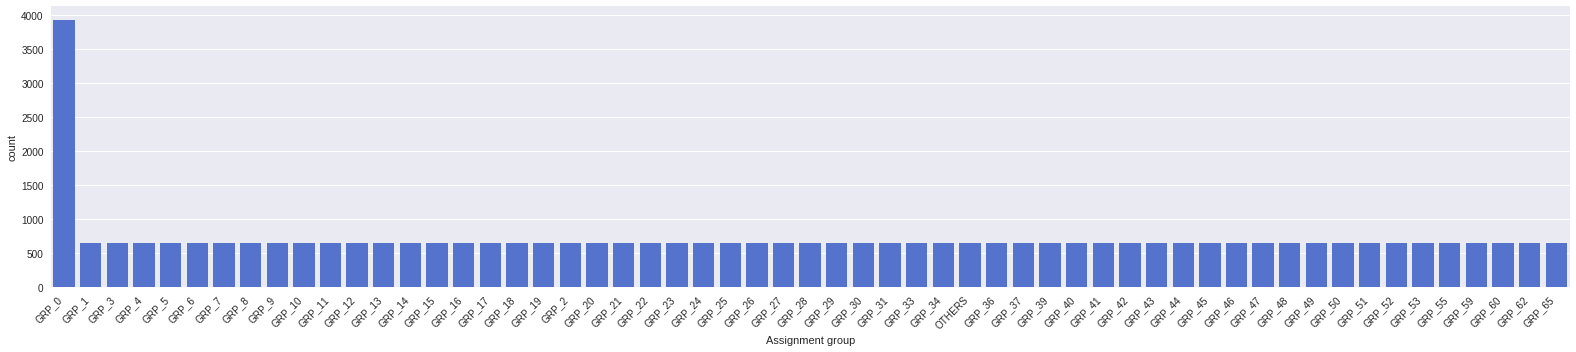

In [66]:
descending_order = df_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=df_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

Since around ~50% of data are tagged to GRP_0 we didn't consider for sampling. 

In [67]:
X=df_resampled['desc_lemma'].apply(lambda x: ' '.join(x))
y=df_resampled['Assignment group']

In [68]:
le = LabelEncoder() 
le.fit(y)
y = le.transform(y)

In [69]:
tfidf = TfidfVectorizer(binary=False, norm='l2', use_idf=True, smooth_idf=True, min_df=1,max_df=1.0,max_features=None,ngram_range=(1,1), stop_words='english')
tfidf.fit(X)
X = tfidf.transform(X)

In [70]:
X.shape

(40054, 14085)

## Feature selection

In [71]:
X = SelectKBest(score_func=chi2,k=5000).fit_transform(X, y)

We have used SelectKBest algorithm to select best 5000 features from 14085 features.

In [72]:
X.shape

(40054, 5000)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Model Building

In [74]:
def precision_recall_fscore_support_roc_auc(model, y_test,X_test):
  y_pred = model.predict(X_test)

  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
  print("Precision: ",precision)
  print("Recall: ",recall)
  print('F1 score: ',f1_score)

  y_proba = model.predict_proba(X_test)

  print("roc_auc value: ",roc_auc_score(y_test, y_proba, labels = model.classes_, average='macro', multi_class='ovo'))
  cf_matrix = confusion_matrix(y_test, y_pred)
  # print('Confusion matrix:\n %s' % (cf_matrix))
  plt.subplots(figsize=(25,10))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12}, cmap='Oranges')

train acc:  0.8896101580054927
test acc:  0.8755929100441042
Precision:  0.8755929100441042
Recall:  0.8755929100441042
F1 score:  0.8755929100441042
roc_auc value:  0.996020584727596


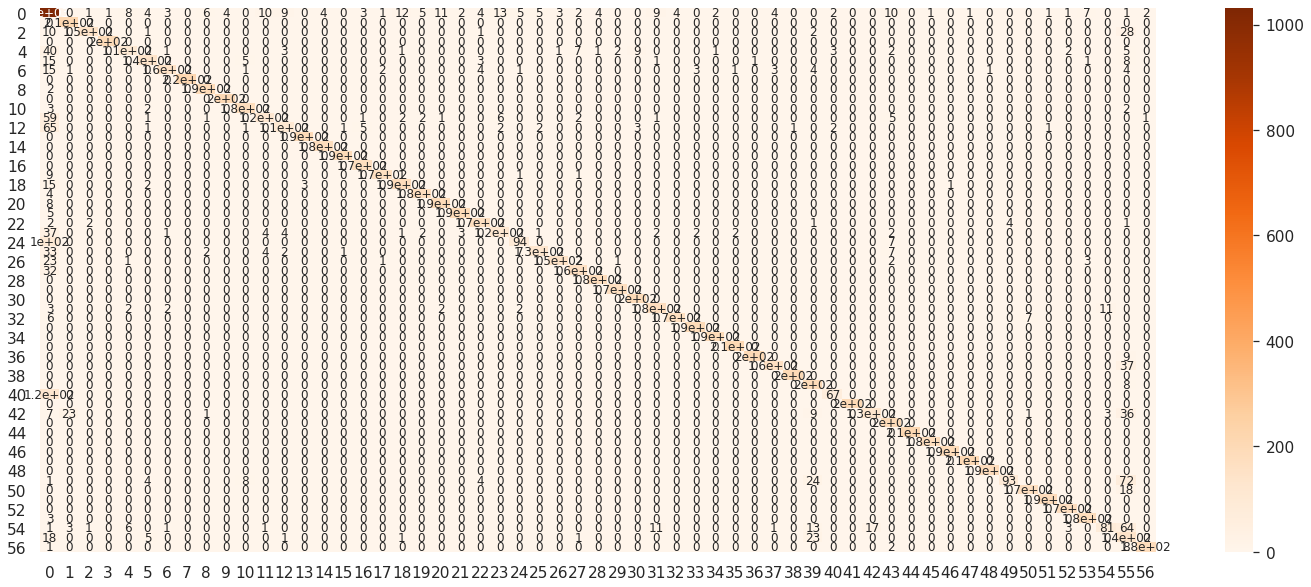

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

In [78]:
clf = RandomForestClassifier(n_estimators = 20, random_state=1,max_features=1.0)

In [79]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [80]:
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=1.0,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False, random_state=1,
                                    

In [81]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [82]:
grid_search.cv_results_['mean_test_score']

array([0.10229339, 0.10229339, 0.10229339, 0.1004744 , 0.1004744 ,
       0.1004744 , 0.09819168, 0.09819168, 0.09819168, 0.10347052,
       0.10347052, 0.10347052, 0.10336351, 0.10336351, 0.10336351,
       0.10282847, 0.10282847, 0.10282847, 0.13878102, 0.13878102,
       0.13874536, 0.13856701, 0.13856701, 0.13856701, 0.13856701,
       0.13856701, 0.13856701, 0.9333736 , 0.9324462 , 0.92927183,
       0.12380052, 0.12380052, 0.12322987, 0.09869103, 0.09869103,
       0.09869103, 0.93319526, 0.93344491, 0.92905781, 0.57359963,
       0.57359963, 0.57324245, 0.12772392, 0.12772392, 0.12772392,
       0.93326655, 0.93290988, 0.9289865 , 0.77568944, 0.77568944,
       0.77347818, 0.58982849, 0.58982849, 0.58982849, 0.10229339,
       0.10229339, 0.10218638, 0.10022475, 0.10022475, 0.10022475,
       0.09837003, 0.09837003, 0.09837003, 0.10318491, 0.10318491,
       0.10318491, 0.10286393, 0.10286393, 0.10286393, 0.10232892,
       0.10232892, 0.10232892, 0.12437122, 0.12437122, 0.12437

In [83]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [86]:
finalModel=grid_search.best_estimator_

In [84]:
num_folds = 10
seed = 1

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
model = grid_search.best_estimator_
results = cross_val_score(model, X_train, y_train, cv=kfold)

print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.93437946 0.93758916 0.93687589 0.93687589 0.93616262 0.94472183
 0.94008559 0.93649661 0.93364253 0.93863717]
Accuracy: 93.755% (0.297%)


train acc:  0.9543103755751329
test acc:  0.9390030789714571
Precision:  0.9390030789714571
Recall:  0.9390030789714571
F1 score:  0.9390030789714571
roc_auc value:  0.9977202751018178


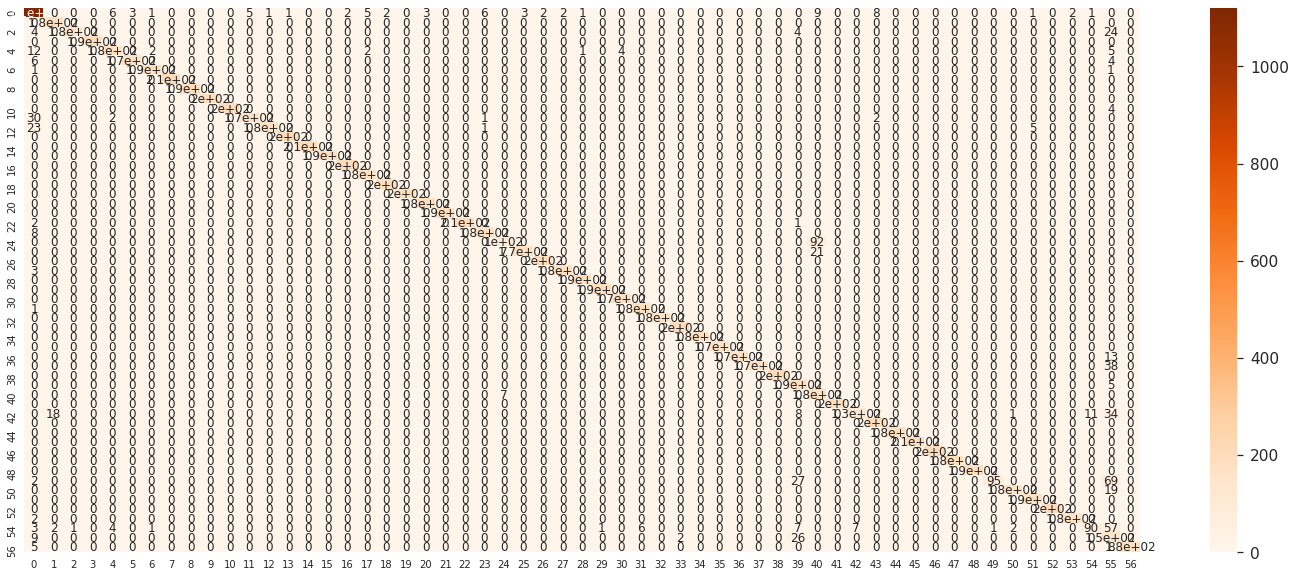

In [85]:
print('train acc: ',model.score(X_train,y_train))
print('test acc: ',model.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(model,y_test,X_test)

train acc:  0.9537753682633663
test acc:  0.918948156777898
Precision:  0.918948156777898
Recall:  0.918948156777898
F1 score:  0.918948156777898
roc_auc value:  0.9909429541086916


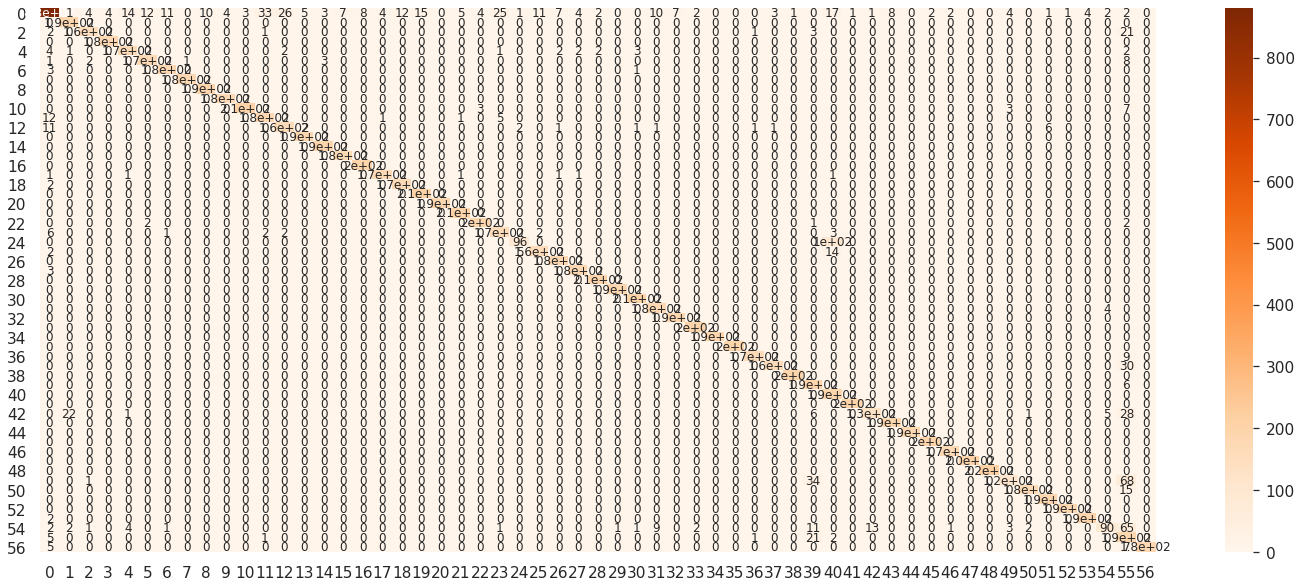

In [ ]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1).fit(X_train, y_train)
print('train acc: ',dTree.score(X_train,y_train))
print('test acc: ',dTree.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(dTree,y_test,X_test)

train acc:  0.953347362413953
test acc:  0.9243571606890238
Precision:  0.9243571606890238
Recall:  0.9243571606890238
F1 score:  0.9243571606890238
roc_auc value:  0.9964819573527265


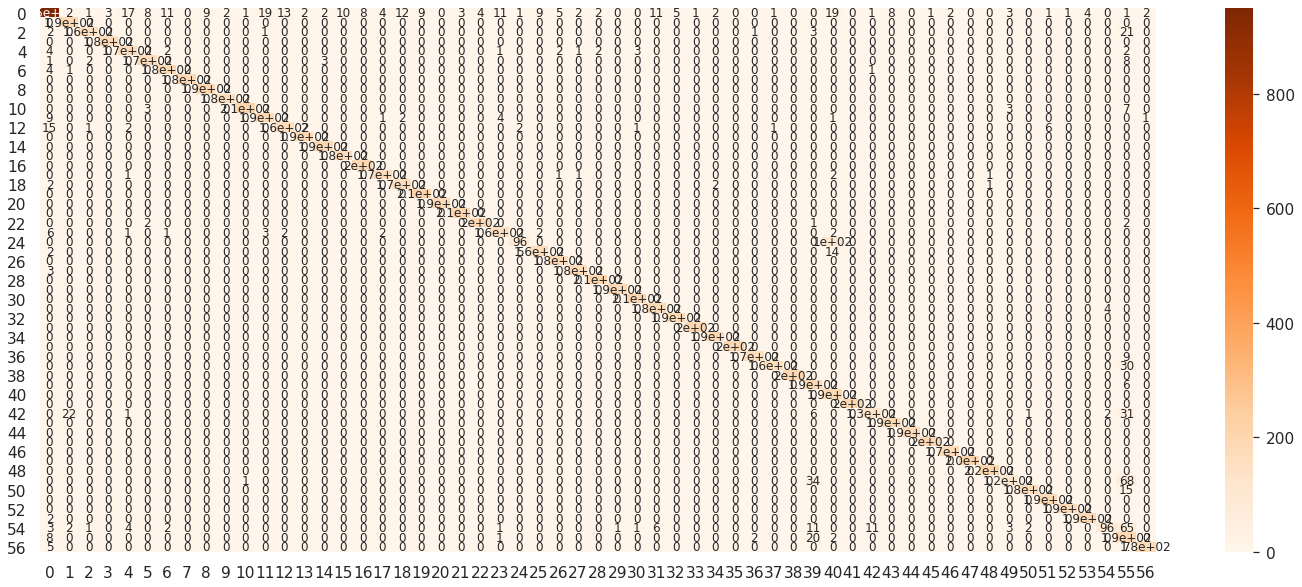

In [ ]:
clf = BaggingClassifier(base_estimator=dTree, n_estimators=30,random_state=1).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

In [ ]:
# build a classifier
clf = XGBClassifier(n_estimators=50, objective="multi:softmax")

In [ ]:
# use a full grid over all parameters
param_grid  = {
    "colsample_bytree": [uniform.rvs(0.7, 0.3)],
    "gamma": [uniform.rvs(0, 0.5)],
    "learning_rate": [uniform.rvs(0.03, 0.3)], # default 0.1 
    "max_depth": [sp_randint.rvs(2, 6)], # default 3
    "n_estimators": [sp_randint.rvs(10, 50)], # default 100
    "subsample": [uniform.rvs(0.6, 0.4)]
}

In [ ]:
# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=50, n_jobs=1,
                                     nthread=None, objective='multi:softmax',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.9682495001693789],
                         'gamma': [0.4337202484488493],
                         'learning_rate': [0.21159700439144

In [ ]:
grid_search.best_params_

{'colsample_bytree': 0.9682495001693789,
 'gamma': 0.4337202484488493,
 'learning_rate': 0.2115970043914408,
 'max_depth': 4,
 'n_estimators': 47,
 'subsample': 0.6716298037275914}

In [ ]:
grid_search.cv_results_['mean_test_score']

array([0.87562886])

In [ ]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9682495001693789,
              gamma=0.4337202484488493, learning_rate=0.2115970043914408,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=47, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6716298037275914, verbosity=1)

In [ ]:
num_folds = 10
seed = 1

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
model = grid_search.best_estimator_
results = cross_val_score(model, X_train, y_train, cv=kfold)

print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.88124108 0.88017118 0.87482168 0.86768902 0.88659058 0.87767475
 0.88088445 0.88690689 0.88476632 0.87263646]
Accuracy: 87.934% (0.591%)


train acc:  0.9070870635232015
test acc:  0.8851626861945577
Precision:  0.8851626861945577
Recall:  0.8851626861945577
F1 score:  0.8851626861945577
roc_auc value:  0.9968502348891265


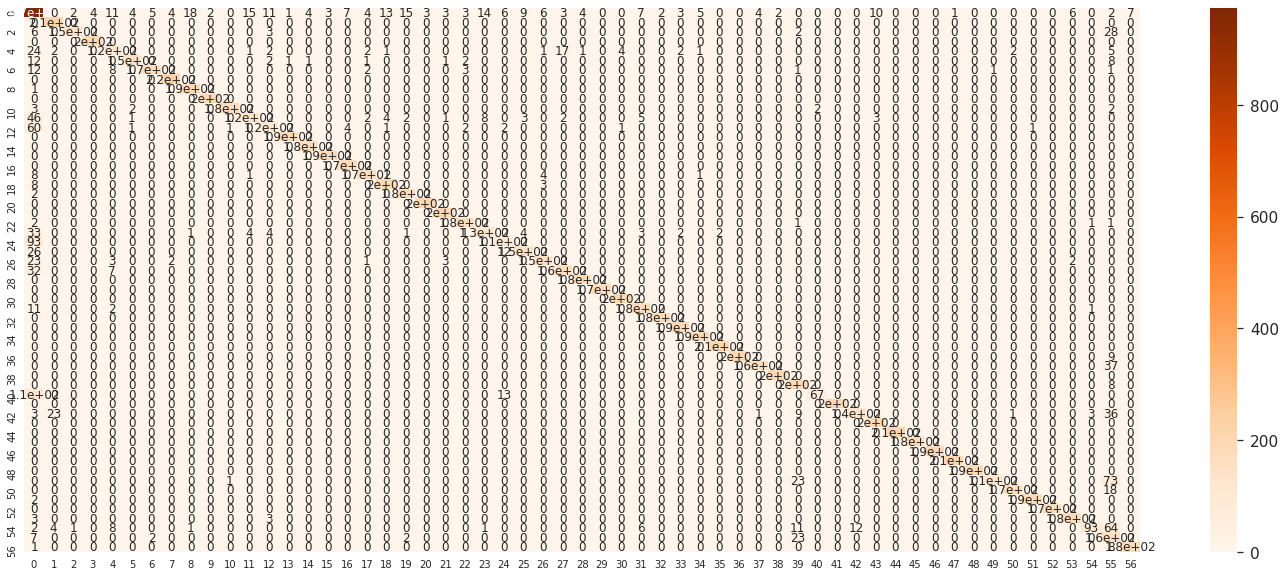

In [ ]:
print('train acc: ',model.score(X_train,y_train))
print('test acc: ',model.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(model,y_test,X_test)

## One layer NN

In [ ]:
X_train=X_train.toarray()
X_test=X_test.toarray()

In [ ]:
# 1 layer NN
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint



def create_model():
  model = Sequential()
  model.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(len(le.classes_)))
  model.add(Activation('softmax'))
  model.compile(metrics=['accuracy'],loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
  return model

model = create_model()
print(model.summary())

batch_size = 16
epochs = 10

bst_model_path = '1-layer-nn-with-tfidf.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, monitor='val_accuracy',save_best_only=True, save_weights_only=True)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data = (X_test,y_test), callbacks = [model_checkpoint])

model = create_model()
model.load_weights('1-layer-nn-with-tfidf.h5')
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 5000)              25005000  
_________________________________________________________________
activation_6 (Activation)    (None, 5000)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 57)                285057    
_________________________________________________________________
activation_7 (Activation)    (None, 57)                0         
Total params: 25,290,057
Trainable params: 25,290,057
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1753/1753 [==============================] - 15s 7ms/step - loss: 3.2523 - accuracy: 0.2335 

In [ ]:
def plotModelAccuracy(history, modelname):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])

  plt.title(modelname+' model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title(modelname+' model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

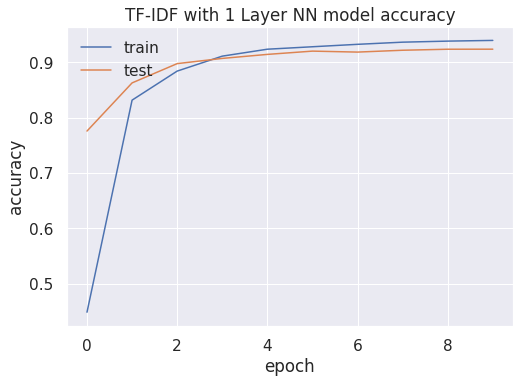

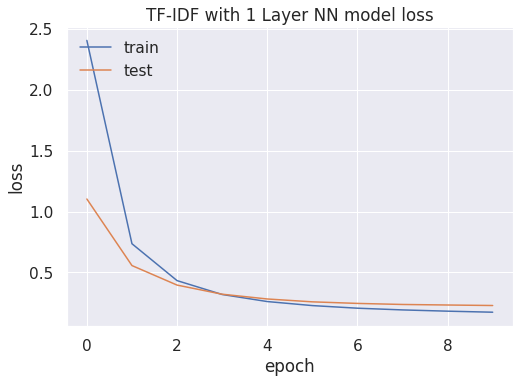

In [ ]:
plotModelAccuracy(history, "TF-IDF with 1 Layer NN")

#LSTM Model

In [ ]:
X=df_resampled['desc_lemma'].apply(lambda x: ' '.join(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
MAX_SEQUENCE_LENGTH = 250
MAX_NB_WORDS = sum(ticket_df['desc_lemma'].map(np.unique).map(len)) + 10000
EMBEDDING_DIM = 300

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(ticket_df['desc_clean'].tolist())

sequences_1 = tokenizer.texts_to_sequences(X_train)
test_sequences_1 = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data_1.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
  token = nlp(word)
  if token.has_vector:
      embedding_matrix[i] = token.vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

rate_drop_lstm = 0.2
rate_drop_lstm = 0.2
rate_drop_dense = 0.5
num_lstm = 200
num_dense = 128

embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

dropped = Dropout(rate_drop_dense)(x1)
normalized = BatchNormalization()(dropped)

x2 = Dense(num_dense, activation='relu')(normalized)
dropped2 = Dropout(rate_drop_dense)(x2)
normalized2 = BatchNormalization()(dropped2)

preds = Dense(len(le.classes_), activation='softmax')(normalized2)


model = Model(inputs=[sequence_1_input], \
        outputs=preds)
model.compile(loss='sparse_categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy'])
model.summary()

bst_model_path = 'lstm.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, monitor='val_accuracy',save_best_only=True, save_weights_only=True)
history = model.fit(data_1, y_train, \
        validation_data=(test_data_1, y_test), \
        epochs=10, batch_size=64, shuffle=True, \
        callbacks=[model_checkpoint])

model.load_weights(bst_model_path)
score = model.evaluate(test_data_1, y_test, batch_size=32, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Found 15243 unique tokens
Shape of data tensor: (28037, 250)
Null word embeddings: 7826
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 250, 300)          4573200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 200)               800       
_________________________________________________________________
dense_16 (Dense)             (None, 128)               25728     
_____________________________________

# Model Deployment

In [87]:
from joblib import dump
def dumpModel(model):
    dump(model, filename="Automatic_Ticket_Assignment_Capstone_Project.joblib")
    print("Model has been searialized")

In [88]:
X=df_resampled['desc_lemma'].apply(lambda x: ' '.join(x))
y=df_resampled['Assignment group']

In [89]:
le = LabelEncoder() 
le.fit(y)
y = le.transform(y)
dump(le, open('classes.pkl', 'wb'))

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [91]:
estimators = []
estimators.append(('tfidf', TfidfVectorizer(binary=False, norm='l2', use_idf=True, smooth_idf=True, min_df=1,max_df=1.0,max_features=None,ngram_range=(1,1), stop_words='english')))
estimators.append(('skb', SelectKBest(score_func=chi2,k=5000)))
estimators.append(('clf',finalModel))

In [92]:
pipe = Pipeline(estimators)
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=10,
                                        max_leaf_nodes=None, max_samples=None,
 

In [93]:
dumpModel(pipe)

Model has been searialized


#Conclusion


 * Data augmentaion techniques helped us in fixing the skewed data
 * Gridsearch CV helps in finding the best hyperparameter
 * Random forest classifier algorithm gives best accuracy.
 * We have used joblib and pickle to dump the model and label encoders respectively.
 * Flask helped us in wrapping the model inside the rest API.
 * End user no need to manually assign the groups instead they can consume the rest API which will do the hardwork of predicting the correct assignment group.